## Sentiment Analysis

1. Lexicon based mathods
2. ML based sentiment classification (requires large training data)
3. LLM based sentiment classification (requires high computation sources)

#### 1. Sentiment classification using Lexicon based methods

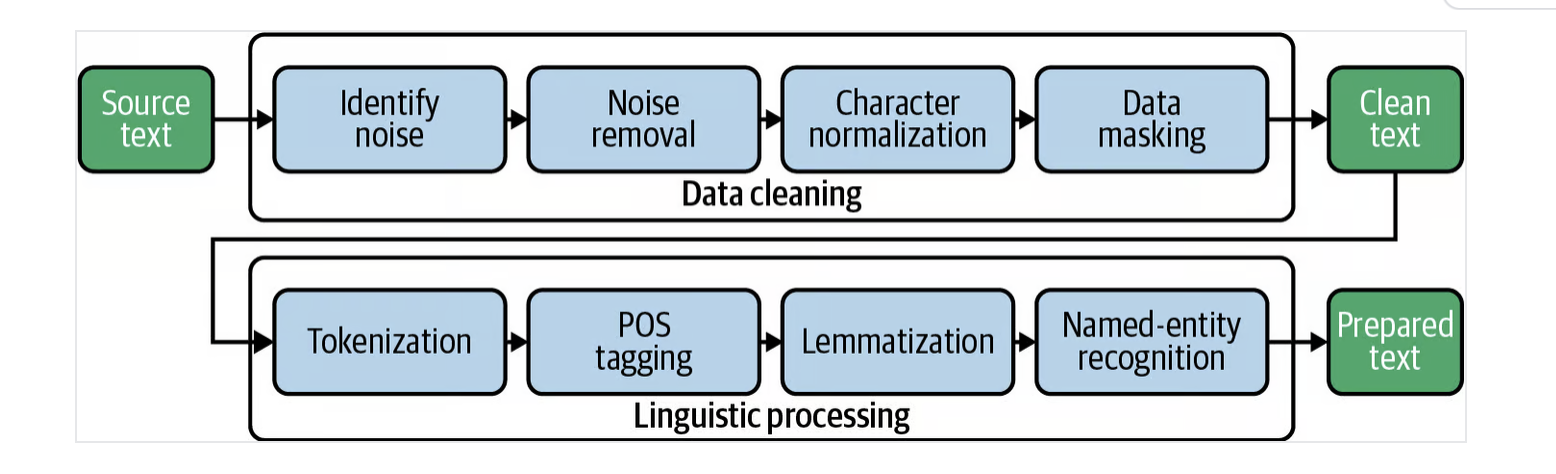

1. noise removal - stop words removal
2. stemming - tranforming the word to its root form by removing suffixes
3. Lemmatization - reducing words to their base form based on their part of speech.

In [30]:
import pandas as pd
import re
import nltk 
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

In [28]:
df = pd.read_csv('datasets/Dataset_10k.csv')
df.head()

,Unnamed: 0,date,title,source,number_of_characters_title,number_of_words_title,day_of_week,month,year,quarter,is_weekend,category
0,0,2024-10-14,"will.i.am and Fyilicia on the AI revolution, i...",Evening Standard,122,20,Monday,October,2024,4,False,Other
1,1,2024-02-21,Intel Launches World’s First Systems Foundry D...,Investor Relations :: Intel Corporation (INTC),117,18,Wednesday,February,2024,1,False,Other
2,2,2024-02-05,The Unique Challenges of Selling Enterprise AI,Emerge,54,9,Monday,February,2024,1,False,Career
3,3,2024-08-28,Contentious California AI bill passes legislat...,Reuters,88,11,Wednesday,August,2024,3,False,Other
4,4,2024-10-15,"Exploring Genius, Creation, and Humanity in th...",University of Aberdeen,82,14,Tuesday,October,2024,4,False,Other


In [31]:
# TEXT PREPROCESSING
def preprocess(text):
    tokens = word_tokenize(text.lower())
    filtered_tokens = [token for token in tokens if token not in stopwords.words('english')]
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]
    processed_text = ' '.join(lemmatized_tokens)
    return processed_text

df['title'] = df['title'].apply(preprocess)
def preprocess1(text):
    # Convert text to lowercase
    text = text.lower()
    tokens = nltk.word_tokenize(text)
    #df['title3'] = df['title1'].apply(lambda x: re.sub(r'(?i)\s*artificial\s+intelligence\s*', ' ai ', x))   # 
    #df['title5'] = df['title'].apply(lambda x: re.sub(r'A\.I\.*', ' ai ', x)) 
    #df['title3'] = df['title3'].apply(lambda x: x.strip())
    token1 = [re.sub(r'[^a-z]',' ', token) for token in tokens]
    token1 = [token for token in token1 if token]
    text = ' '.join(token1)
    return text
df['title1']=df['title'].apply(preprocess1)
stop_words = set(stopwords.words('english'))
def remove_stop_words(text,stop_words):
    tl = text.split()
    l=[]
    for word in tl:
        if word not in stop_words:
            l.append(word)
    text = ' '.join(l)
    return text
df['title1']=df['title1'].apply(lambda x: remove_stop_words(x,stop_words))
# changing artificial intelligence to ai
df['title3'] = df['title1'].apply(lambda x: re.sub(r'(?i)\s*artificial\s+intelligence\s*', ' ai ', x))
df['title3'] = df['title3'].apply(lambda x: x.strip())
# removing consecutive ai terms
df['title4']=df['title3'].apply(lambda x:  re.sub(r'(ai\s+)+', 'ai ', x))
df['title4'] = df['title4'].apply(lambda x: x.strip())

#####  Vader 
specifically attuned to sentiments expressed in social media

In [93]:
analyzer = SentimentIntensityAnalyzer()

def get_sentiment(text):
    score = analyzer.polarity_scores(text)
    sentiment = 1 if score['compound']>0 else 0
    return sentiment
df['sentiment'] = df['title4'].apply(get_sentiment)

In [94]:
df['sentiment'].value_counts()

sentiment
0    6238
1    3760
Name: count, dtype: int64

##### Textblob

In [34]:
#!pip install textblob
from textblob import TextBlob

In [42]:
def textblob(text):
    b = TextBlob(text).sentiment
    polarity = 1 if b.polarity>0 else 0
    opinion_fact = 1 if b.subjectivity>0.5 else 0
    return polarity,opinion_fact

df[['tb_polarity','tb_opinion_fact']] = df['title4'].apply(textblob).apply(pd.Series)
#df.head()

In [95]:
pd.crosstab(index=df['sentiment'], columns=df['tb_polarity'])

tb_polarity,0,1
sentiment,,
0,5109,1129
1,2079,1681


In [44]:
pd.crosstab(index=df['tb_polarity'], columns=df['tb_opinion_fact'])

tb_opinion_fact,0,1
tb_polarity,,
0,6605,585
1,1876,934


In [45]:
df['vader_sentiment'] = df['title4'].apply(lambda x: analyzer.polarity_scores(x)['compound'])
df['tb_sentiment']=df['title4'].apply(lambda x: TextBlob(x).sentiment.polarity)

##### afinn

In [46]:
#!pip install afinn
from afinn import Afinn

afn = Afinn()

df['afinn_score']=df['title4'].apply(lambda x: afn.score(x))

In [47]:
df[['vader_sentiment','tb_sentiment','afinn_score']].describe()

,vader_sentiment,tb_sentiment,afinn_score
count,10000.000000,10000.000000,10000.0000
mean,0.096578,0.050955,0.3137
std,0.314556,0.200458,1.7102
min,-0.946000,-1.000000,-11.0000
25%,0.000000,0.000000,0.0000
50%,0.000000,0.000000,0.0000
75%,0.340000,0.083333,1.0000
max,0.964300,1.000000,14.0000


#### sentiment classification using pretrained models

##### 1.Flair - classification model en-sentiment has been trained on IMDB dataset.

In [50]:
#pip install flair
from flair.models import TextClassifier
from flair.data import Sentence
classifier = TextClassifier.load('en-sentiment')

In [56]:
df=df[df['title4']!='']

In [57]:
for index,row in df.iterrows():
    text = row['title4']
    sentence = Sentence(text)
    classifier.predict(sentence)
    sentiment = sentence.labels[0].value
    score = sentence.labels[0].score
    df.loc[index,'flair_sentiment'] = sentiment
    df.loc[index,'flair_score'] = score
df.head()

,Unnamed: 0,date,title,source,number_of_characters_title,number_of_words_title,day_of_week,month,year,quarter,...,title3,title4,sentiment,tb_polarity,tb_opinion_fact,vader_sentiment,tb_sentiment,afinn_score,flair_sentiment,flair_score
0,0,2024-10-14,"will.i.am fyilicia ai revolution , inclusivity...",Evening Standard,122,20,Monday,October,2024,4,...,fyilicia ai revolution inclusivity voice uk te...,fyilicia ai revolution inclusivity voice uk te...,0,0,0,0.0000,0.000,0.0,NEGATIVE,0.794137
1,1,2024-02-21,intel launch world ’ first system foundry desi...,Investor Relations :: Intel Corporation (INTC),117,18,Wednesday,February,2024,1,...,intel launch world first system foundry design...,intel launch world first system foundry design...,0,1,0,0.0000,0.250,0.0,POSITIVE,0.997875
2,2,2024-02-05,unique challenge selling enterprise ai,Emerge,54,9,Monday,February,2024,1,...,unique challenge selling enterprise ai,unique challenge selling enterprise ai,1,1,1,0.0772,0.375,-1.0,POSITIVE,0.999678
3,3,2024-08-28,contentious california ai bill pas legislature...,Reuters,88,11,Wednesday,August,2024,3,...,contentious california ai bill pas legislature...,contentious california ai bill pas legislature...,1,0,0,-0.2263,0.000,-3.0,NEGATIVE,0.884658
4,4,2024-10-15,"exploring genius , creation , humanity age ai",University of Aberdeen,82,14,Tuesday,October,2024,4,...,exploring genius creation humanity age ai,exploring genius creation humanity age ai,1,0,0,0.2732,0.000,0.0,POSITIVE,0.999715


In [58]:
df['flair_sentiment'].value_counts()

flair_sentiment
POSITIVE    5754
NEGATIVE    4244
Name: count, dtype: int64

In [59]:
pd.crosstab(index=df['tb_polarity'],columns=df['flair_sentiment'])

flair_sentiment,NEGATIVE,POSITIVE
tb_polarity,,
0,3400,3788
1,844,1966


In [60]:
df[['flair_sentiment','flair_score']]

,flair_sentiment,flair_score
0,NEGATIVE,0.794137
1,POSITIVE,0.997875
2,POSITIVE,0.999678
3,NEGATIVE,0.884658
4,POSITIVE,0.999715
...,...,...
9995,POSITIVE,0.992564
9996,NEGATIVE,0.999816
9997,POSITIVE,0.970770
9998,NEGATIVE,0.580735


##### 2.Pretrained model - (DistilBERT base uncased finetuned SST-2)

In [132]:
text = "contentious california ai bill pass legislature , awaits governor 's signature"


In [61]:
from transformers import pipeline
sentiment_pipeline = pipeline('sentiment-analysis') # default model is DistilBERT base uncased finetuned SST-2


In [62]:
def sentiment_analysis(text):
    label = sentiment_pipeline(text)[0]['label']
    score = sentiment_pipeline(text)[0]['score']
    return label,score

df[['sent1','sent1_score']] = df['title4'].apply(sentiment_analysis).apply(pd.Series)

In [63]:
df['sent1'].value_counts(),df['flair_sentiment'].value_counts()

(sent1
 NEGATIVE    5464
 POSITIVE    4534
 Name: count, dtype: int64,
 flair_sentiment
 POSITIVE    5754
 NEGATIVE    4244
 Name: count, dtype: int64)

In [64]:
pd.crosstab(index=df['flair_sentiment'],columns=df['sent1'])

sent1,NEGATIVE,POSITIVE
flair_sentiment,,
NEGATIVE,3789,455
POSITIVE,1675,4079


#### Visualizing words of a Sentiment

In [65]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [79]:
df.head()

,Unnamed: 0,date,title,source,number_of_characters_title,number_of_words_title,day_of_week,month,year,quarter,...,vader_sentiment,tb_sentiment,afinn_score,flair_sentiment,flair_score,sent1,sent1_score,Year,Quarter,Month
0,0,2024-10-14,"will.i.am fyilicia ai revolution , inclusivity...",Evening Standard,122,20,Monday,October,2024,4,...,0.0000,0.000,0.0,NEGATIVE,0.794137,NEGATIVE,0.987784,2024,2024Q4,2024-10
1,1,2024-02-21,intel launch world ’ first system foundry desi...,Investor Relations :: Intel Corporation (INTC),117,18,Wednesday,February,2024,1,...,0.0000,0.250,0.0,POSITIVE,0.997875,POSITIVE,0.987248,2024,2024Q1,2024-02
2,2,2024-02-05,unique challenge selling enterprise ai,Emerge,54,9,Monday,February,2024,1,...,0.0772,0.375,-1.0,POSITIVE,0.999678,POSITIVE,0.999709,2024,2024Q1,2024-02
3,3,2024-08-28,contentious california ai bill pas legislature...,Reuters,88,11,Wednesday,August,2024,3,...,-0.2263,0.000,-3.0,NEGATIVE,0.884658,NEGATIVE,0.982931,2024,2024Q3,2024-08
4,4,2024-10-15,"exploring genius , creation , humanity age ai",University of Aberdeen,82,14,Tuesday,October,2024,4,...,0.2732,0.000,0.0,POSITIVE,0.999715,POSITIVE,0.999711,2024,2024Q4,2024-10


Text(0.5, 1.0, 'Word Cloud for title')

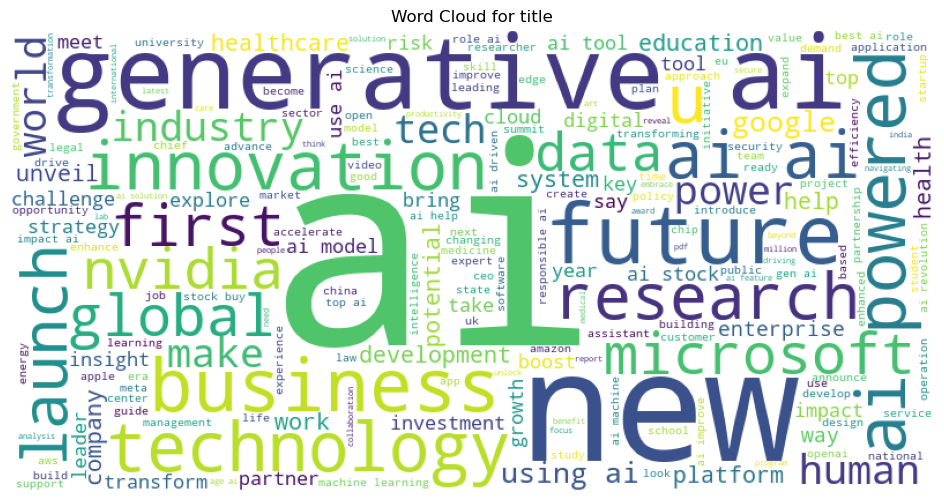

In [67]:
df1 = df[df['sent1']=='POSITIVE']
title_text = ' '.join(df1['title4'].tolist())
wordcloud1 = WordCloud(width=800, height=400, background_color='white').generate(title_text)
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud1)
plt.axis('off')
plt.title('Word Cloud for title')

Text(0.5, 1.0, 'Word Cloud for title')

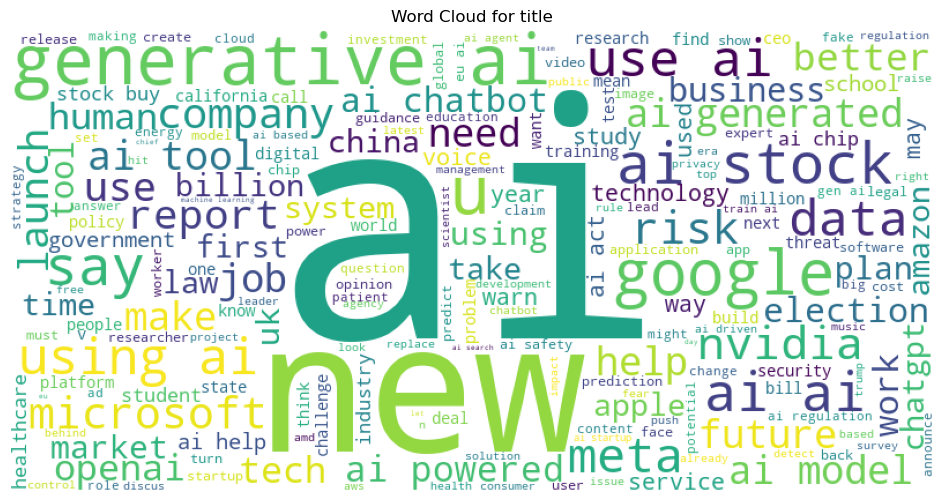

In [68]:
df1 = df[df['sent1']=='NEGATIVE']
title_text = ' '.join(df1['title4'].tolist())
wordcloud1 = WordCloud(width=800, height=400, background_color='white').generate(title_text)
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud1)
plt.axis('off')
plt.title('Word Cloud for title')

In [1]:
import re
import nltk
from nltk.util import ngrams
from collections import Counter
import seaborn as sns

In [69]:
def generate_bar_graphs1(df, title,n=2, top_k=20,n1=1):
    #tokens = ' '.join(df[title].tolist()).split()
    tokens = ' '.join(df[title].tolist())
    #text = ' '.join([word for word in df['title1'].split().sum() if word.lower() not in stop_words])
    # Generate n-grams
    tokens = re.sub(r'(ai\s+)+', 'ai ', tokens)
    tokens = tokens.split()
    ng= list(ngrams(tokens, n))
    # Join n-grams into single strings
    text_ng = [' '.join(gram) for gram in ng]
    # Count frequency of each n-gram
    ng_count = Counter(text_ng)
    # Select top-k most common n-grams
    n2=top_k*(n1-1) # start index
    k = top_k*n1 # end index
    ng_common = ng_count.most_common(k)
    ng_common = ng_common[n2:k]
    plt.figure(figsize=(12, 4))
    bars = plt.bar(
        [item[0] for item in ng_common],  # x-axis: n-grams
        [item[1] for item in ng_common],  # y-axis: counts
        color='skyblue')
    #plt.bar([item[0] for item in ng_common], [item[1] for item in ng_common], color='skyblue')
    # Add count values on top of each bar (value on the y-axis)
    for bar in bars:
        height = bar.get_height()  # Get the height of the bar (frequency)
        plt.text(
            bar.get_x() + bar.get_width() / 2,  # X position of the text (center of the bar)
            height,                             # Y position of the text (top of the bar)
            f'{int(height)}',                   # Text to display (convert to integer)
            ha='center',                        # Horizontal alignment
            va='bottom',                        # Vertical alignment
            fontsize= 8                          # Font size of the text
        )
    plt.xlabel('Frequency')
    plt.title(f'Top {top_k} {n}-grams :list {n1}')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

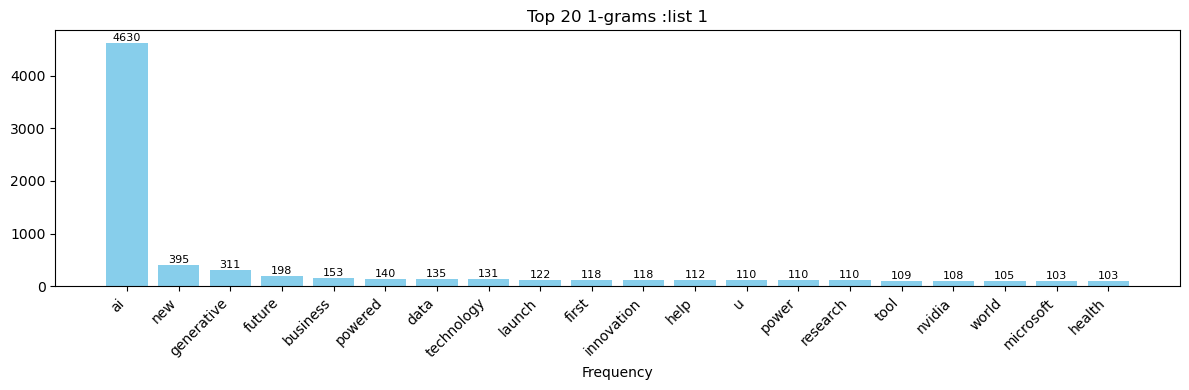

In [99]:
df1 = df[df['sent1']=='POSITIVE']
generate_bar_graphs1(df1,'title4',1,20,1)

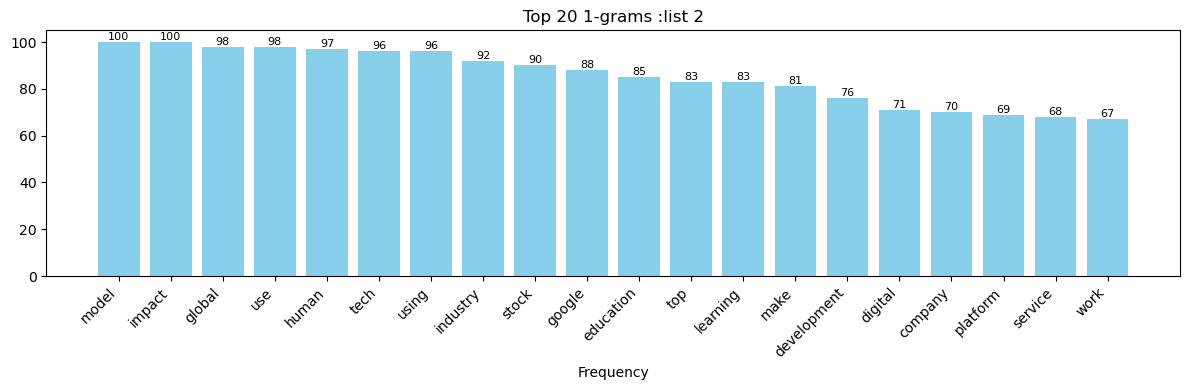

In [100]:
df1 = df[df['sent1']=='POSITIVE']
generate_bar_graphs1(df1,'title4',1,20,2)

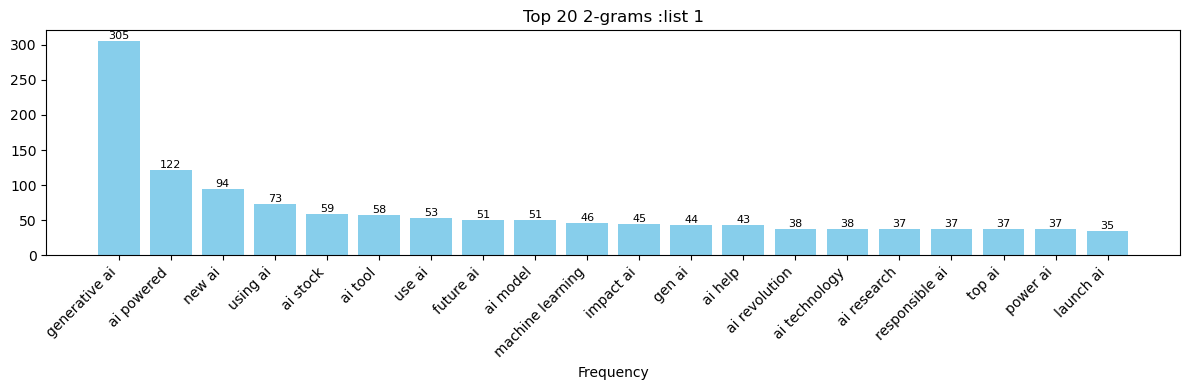

In [101]:
df1 = df[df['sent1']=='POSITIVE']
generate_bar_graphs1(df1,'title4',2,20,1)

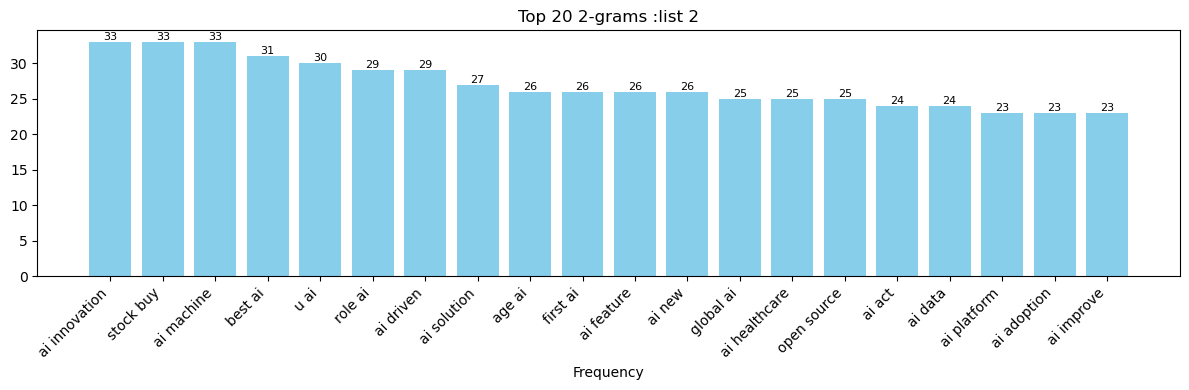

In [102]:
df1 = df[df['sent1']=='POSITIVE']
generate_bar_graphs1(df1,'title4',2,20,2)

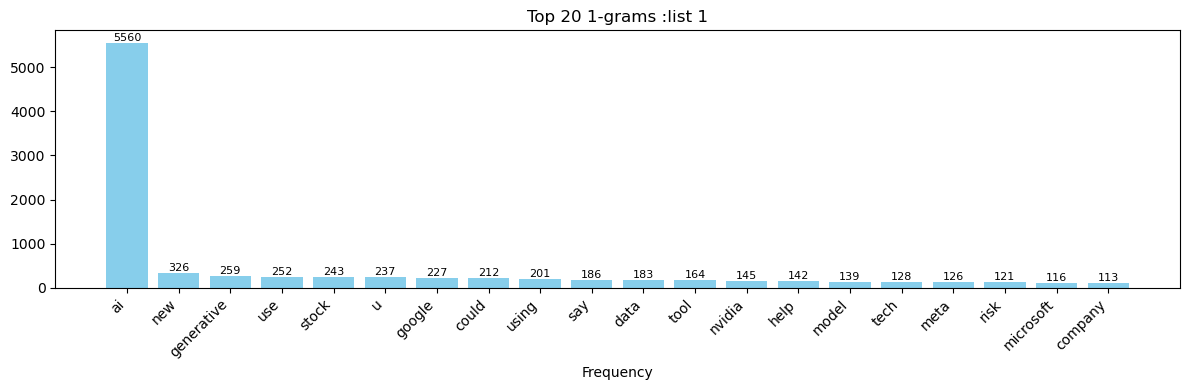

In [103]:
df1 = df[df['sent1']=='NEGATIVE']
generate_bar_graphs1(df1,'title4',1,20,1)

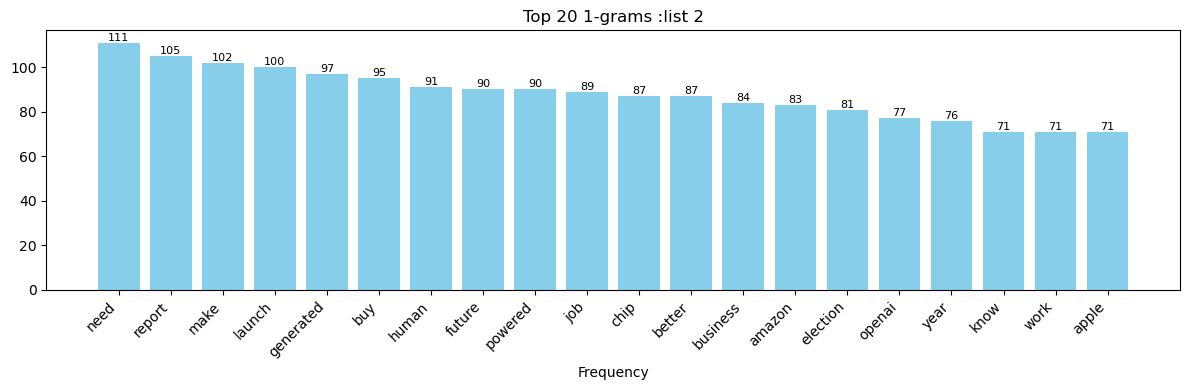

In [104]:
df1 = df[df['sent1']=='NEGATIVE']
generate_bar_graphs1(df1,'title4',1,20,2)

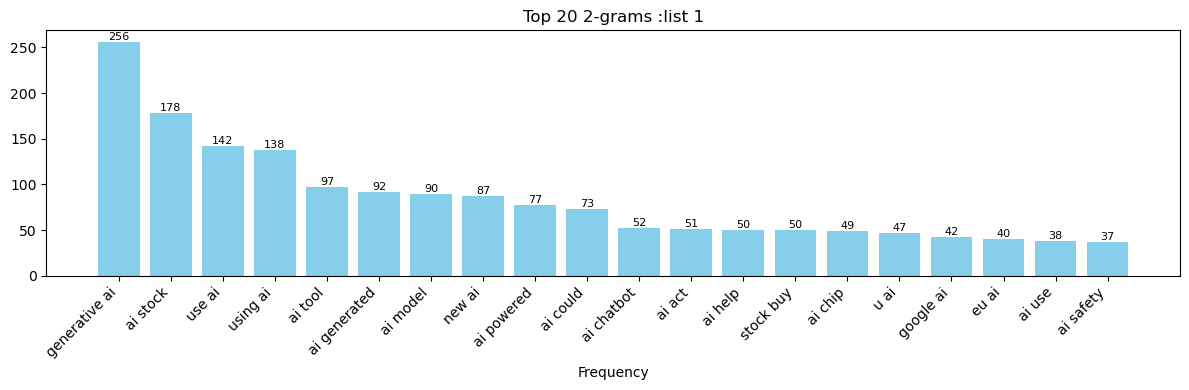

In [105]:
df1 = df[df['sent1']=='NEGATIVE']
generate_bar_graphs1(df1,'title4',2,20,1)

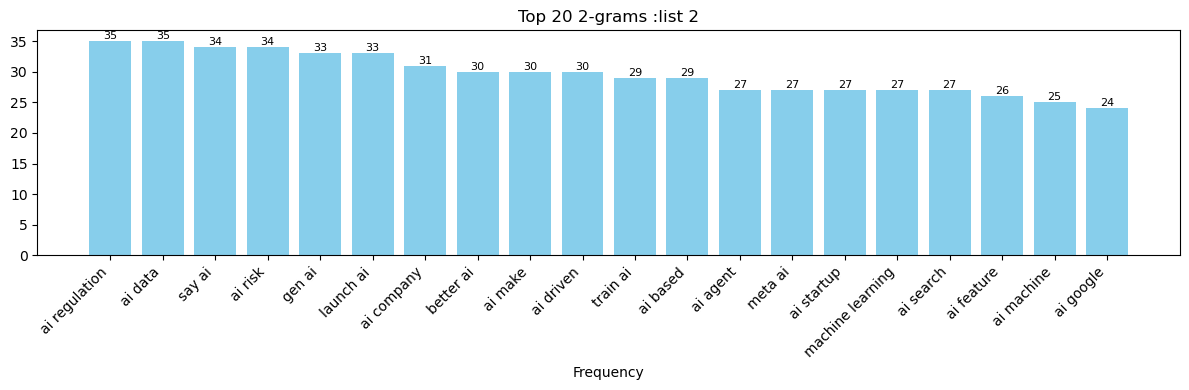

In [106]:
df1 = df[df['sent1']=='NEGATIVE']
generate_bar_graphs1(df1,'title4',2,20,2)

###  Text Sentiments over time

In [78]:
# converting date to datetime format
df['date']=pd.to_datetime(df['date'])
df['Year']=df['date'].dt.year
df['Quarter']=df['date'].dt.to_period('Q')
df['Month']=df['date'].dt.to_period('M')

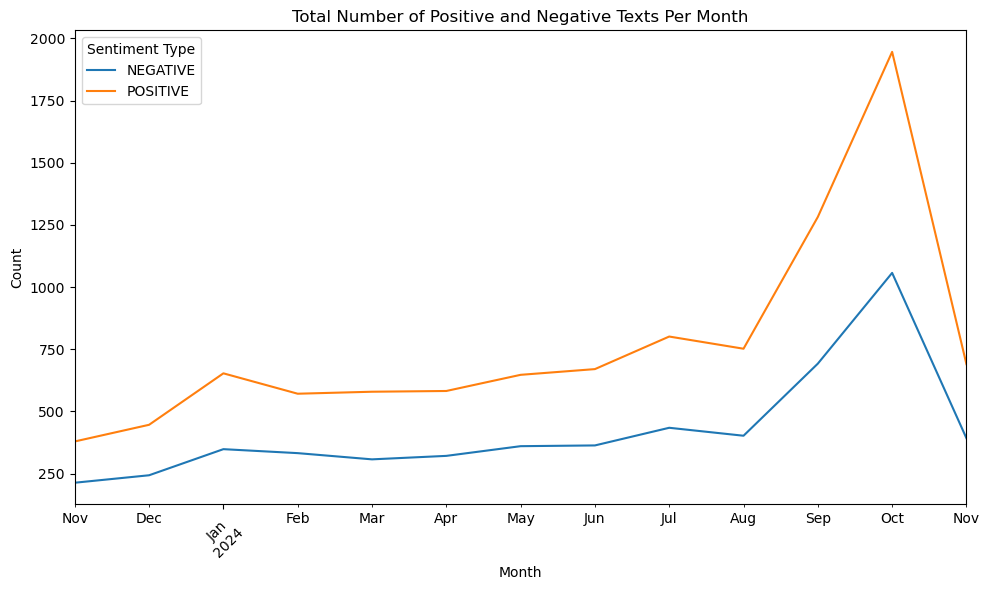

In [85]:
# Group by month and sentiment type, and count the number of texts
sentiment_counts = df.groupby(['Month', 'sent1']).size().unstack(fill_value=0)

# Plot a bar chart
sentiment_counts.plot(kind='line', figsize=(10, 6), stacked=True)
plt.title('pre-trained sentiment analyzers Text sentiments over Months')
plt.xlabel('Month')
plt.ylabel('Count')
plt.legend(title='Sentiment Type')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

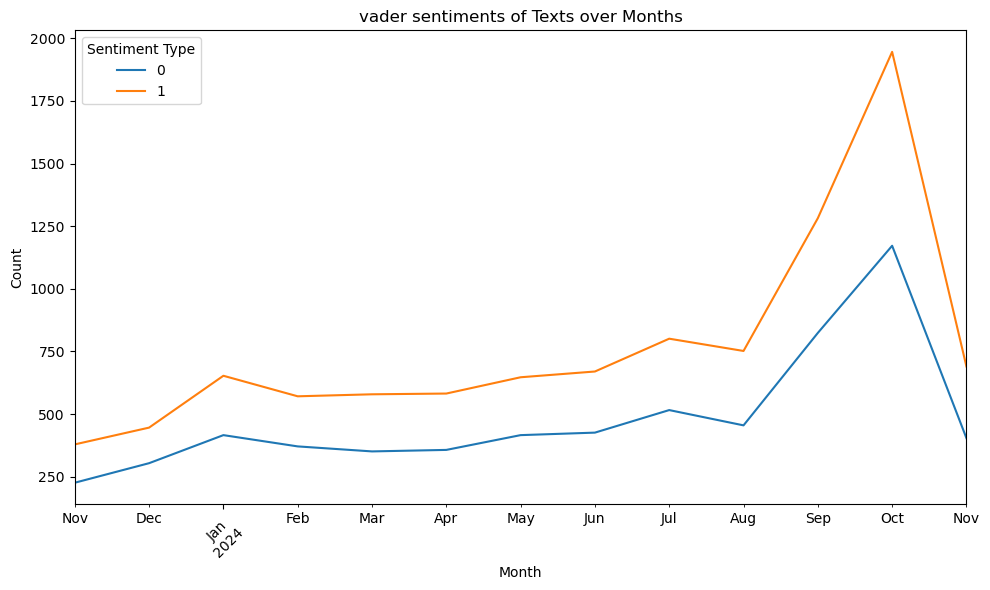

In [109]:
# Group by month and sentiment type, and count the number of texts
sentiment_counts = df.groupby(['Month', 'sentiment']).size().unstack(fill_value=0)

# Plot a bar chart
sentiment_counts.plot(kind='line', figsize=(10, 6), stacked=True)
plt.title('vader sentiments of Texts over Months')
plt.xlabel('Month')
plt.ylabel('Count')
plt.legend(title='Sentiment Type')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

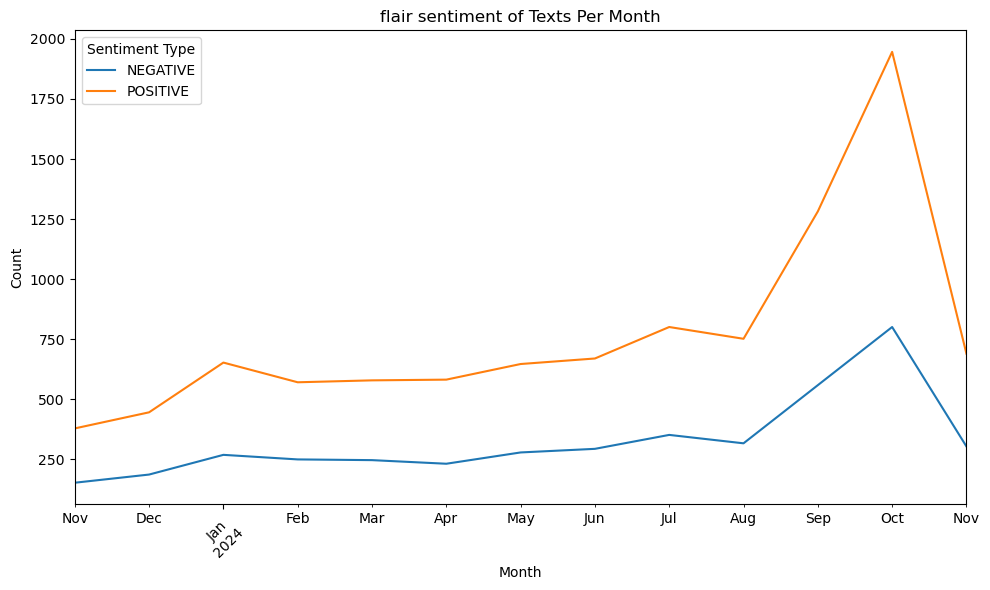

In [108]:
# Group by month and sentiment type, and count the number of texts 
sentiment_counts = df.groupby(['Month', 'flair_sentiment']).size().unstack(fill_value=0)

# Plot a bar chart
sentiment_counts.plot(kind='line', figsize=(10, 6), stacked=True)
plt.title('flair sentiment of Texts Per Month')
plt.xlabel('Month')
plt.ylabel('Count')
plt.legend(title='Sentiment Type')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
df.to_csv('sentiment2-2.csv')

### Observations:

1. Obtained different sentiment scores for the text whihc will be used in further analysis.
2. The lexical based sentiments seem to not cover the sentiment of the headline with the consideration of context.
3. The roberta seems to be covering the sentiment with context.
4. Overall the positive and negative sentiments seem to change in same pattern but with frequency of positive being more than the negative.